In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('F:/JupyterML/ML_Practice/datasets/AirPassengers.csv')

In [3]:
train.head(4)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129


In [5]:
train.timestamp = pd.to_datetime(train.Month , format = '%Y-%m')
train.index = train.timestamp
train.drop('Month',axis = 1, inplace = True)

In [6]:
train.head(4)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129


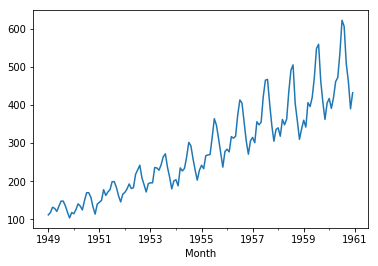

In [7]:
train['#Passengers'].plot()

# ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section)

In [8]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(train['#Passengers'])

C:\Users\apanda88\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. We will understand the trend stationarity in detail in the next section. For now, let’s focus on the implementation and see the results of the KPSS test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary)

In [12]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
#apply KPSS test on the series
kpss_test(train['#Passengers'])

Results of KPSS Test:
Test Statistic            1.052175
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\apanda88\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For the air passenger data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

I usually perform both the statistical tests before I prepare a model for my time series data. It once happened that both the tests showed contradictory results. One of the tests showed that the series is stationary while the other showed that the series is not! I got stuck at this part for hours, trying to figure out how is this possible. As it turns out, there are more than one type of stationarity.

So in summary, the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series

# Types of Stationarity

##Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
##Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
##Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test

##It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

##Case 1: Both tests conclude that the series is not stationary -> series is not stationary
##Case 2: Both tests conclude that the series is stationary -> series is stationary
##Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
##/Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

# Making a Time Series Stationary

# Differencing

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

In [13]:
train['#Passengers_diff'] = train['#Passengers'] - train['#Passengers'].shift(1)

In [14]:
train.head(4)

,#Passengers,#Passengers_diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0


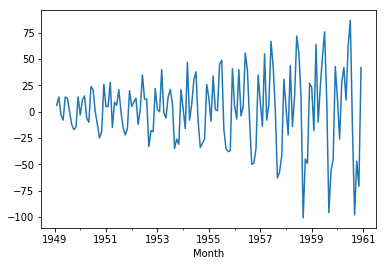

In [15]:
train['#Passengers_diff'].dropna().plot()

# Seasonal Differencing

In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

yt‘ = yt – y(t-n)

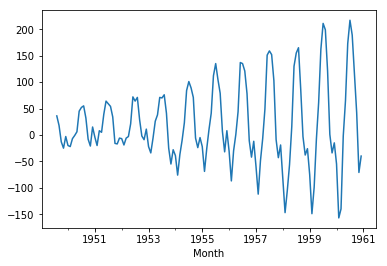

In [16]:
n=7
train['#Passengers_diff'] = train['#Passengers'] - train['#Passengers'].shift(n)
train['#Passengers_diff'].dropna().plot()

# Transformation

Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our air passenger dataset

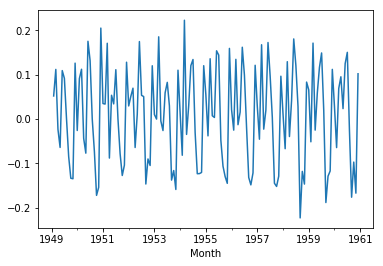

In [19]:
import numpy as np
train['#Passengers_log'] = np.log(train['#Passengers'])
train['#Passengers_log_diff'] = train['#Passengers_log'] - train['#Passengers_log'].shift(1)
train['#Passengers_log_diff'].dropna().plot()